In [51]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
from scipy.stats import norm
import math
from time import time

# define the time-dependent MLP-UNet

In [52]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)
    
def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

# Pretraining

In [53]:
# def denoising_loss(net, batch_data, eps = 1e-5):
#     batch_len = len(batch_data)
#     noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
#     noise = torch.randn(batch_data.shape).cuda()
#     noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
#     predicted_noise = net(noisy_data, noisy_levels)
#     loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
#     return loss

# EPOCH = 1000

# lr=1e-4
# batch_size = 32

# model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model.load_state_dict(deepcopy(model.state_dict()))
# train_data = train_data.cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# progress = tqdm(range(EPOCH))
# for epoch in progress:
#     avg_loss = 0
#     totals = 0
#     for batch_idx in index_iterator(len(train_data), batch_size):
#         optimizer.zero_grad()
#         loss  = denoising_loss(model, train_data[batch_idx])
#         loss.backward()
#         optimizer.step()
#         totals += len(batch_idx)
#         avg_loss += loss.item() * len(batch_idx)
    
#     for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
#         ema_p.data.mul_(0.99).add_(0.01, p.data)

#     progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

#     if (epoch + 1) % 50 == 0:
#         ema_sample_points = ddim_sampling(EMA_model, 1000, eta = 0.3)
#         sample_points = ddim_sampling(model, 1000, eta = 0.3)
#         ema_sample_points_eta0 = ddim_sampling(EMA_model, 1000, eta = 0.)
#         sample_points_eta0 = ddim_sampling(model, 1000, eta = 0.)
#         plt.figure(figsize=(5,5))
#         plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
#         plt.scatter(ema_sample_points[:,0], ema_sample_points[:,1], s=5,alpha=0.6, label="b")
#         plt.scatter(sample_points_eta0[:,0], sample_points_eta0[:,1], s=5,alpha=0.6, label="c")
#         plt.scatter(ema_sample_points_eta0[:,0], ema_sample_points_eta0[:,1], s=5,alpha=0.6, label="d")
#         plt.xlim(-2,2)
#         plt.ylim(-2,2)
#         plt.legend()
#         plt.title("epoch: {}".format(epoch))
#         plt.savefig("temp_results/ddim_{}_mg.png".format(epoch))
#         plt.show()
#         torch.save(model.state_dict(), "temp_results/ddim_mg.pth".format(epoch))
#         torch.save(EMA_model.state_dict(), "temp_results/ddim_ema_mg.pth".format(epoch))
#         print("saved at epoch {}".format(epoch))

# Generation function

In [54]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1., return_all = False):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    if return_all:
        all_points = []
        all_points.append(sample_points.clone())
        all_logits = []
        all_coeffs = []

    for _ in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        sample_points = sample_mean + nl * torch.randn(sample_size,2).cuda()
        
        if return_all:
            all_points.append(sample_points.clone())
            log_likelihood = torch.sum(
                            -((sample_points - sample_mean ) ** 2) / (2 * (nl**2))
                        , dim = 1)
            all_logits.append(log_likelihood)
            all_coeffs.append(now_coeff)
        
        now_coeff -= interp

    if return_all:
        all_coeffs.append(now_coeff)
        return sample_points.cpu().numpy(), all_points, all_logits, all_coeffs
    
    else:
        return sample_points.cpu().numpy()


# pretrained dataset

In [55]:
data_dim = 2
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("ddim_ema_mg.pth"))

<All keys matched successfully>

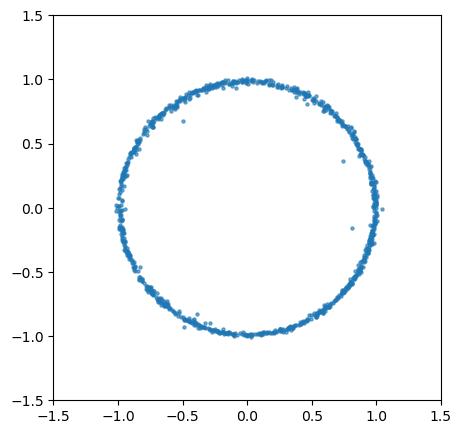

In [56]:
sample_points = ddim_sampling(model, 1000, total_steps=50, eta = 1)
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

# reward function

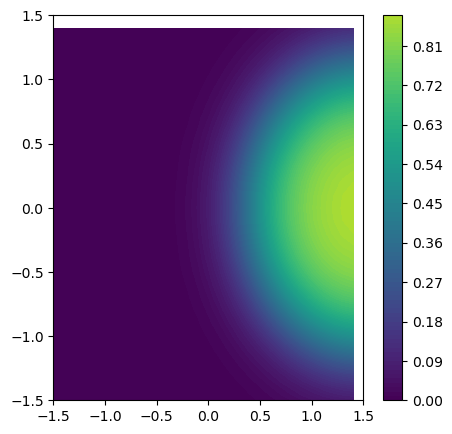

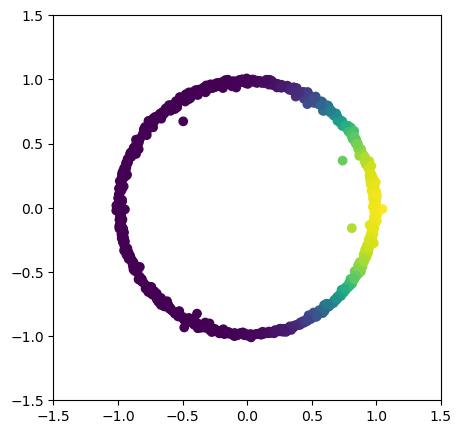

In [57]:
reward_fn = lambda x: 1 / (1 + np.exp(2* (x[:,0] - 1.5) ** 2  +2*(x[:,1] - 0) ** 2 - 2))
# visualize reward fn
x1, x2 = np.meshgrid(np.arange(-1.5,1.5, 0.1), np.arange(-1.5,1.5, 0.1))
z_values = reward_fn(np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)],axis=1)).reshape(x1.shape)
plt.figure(figsize=(5,5))
plt.contourf(x1,x2,z_values,100)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.clim(0,1)
plt.colorbar()

reward_data = reward_fn(sample_points)
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0],sample_points[:,1],c=reward_data)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.colorbar() 
plt.show()

# reward optimization

### evaluation utils

In [58]:
def ddim_sampling_with_kl(model, ref_model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    kl = 0
    for _ in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            ref_direction = ref_model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        ref_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * ref_direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * ref_direction
        sample_points = sample_mean + nl * torch.randn(sample_size,2).cuda()
        kl += torch.sum(((sample_mean - ref_mean) / nl) ** 2, dim = 1).mean()
        
        now_coeff -= interp
    return sample_points.cpu().numpy(), kl

class logger:
    def __init__(self, eval_quantile = [0, 0.05, 0.1, 0.3, 0.5]):
        self.log = {
                    "reward_mean":[],
                    "reward_std":[],
                    "eval_samples":[],
                    "kl_upper":[],
                    "num_backprop":[]
                }
        self.log["quantile"] = {}
        for q in eval_quantile:
            self.log["quantile"][q] = []
        self.start_time = time()
        self.logged_time = []
        

    def update(self, eval_rewards, eval_sample_points, num_backprop, eval_kl_upper):
        self.log["reward_mean"].append(eval_rewards.mean())
        self.log["reward_std"].append(eval_rewards.std())
        self.log["eval_samples"].append(eval_sample_points.copy())
        self.log["num_backprop"].append(num_backprop)
        self.log["kl_upper"].append(eval_kl_upper.item())
        for q in self.log["quantile"].keys():
            self.log["quantile"][q].append(np.quantile(eval_rewards,q))
        self.logged_time.append(time() - self.start_time)
        
    def visualize(self):
        stats = self.log
        plt.figure(figsize=(30,3))
        plt.subplot(151)
        plt.plot(self.logged_time,stats["reward_mean"])
        plt.xlabel("Time (s)")
        plt.ylabel("reward mean")
        plt.subplot(152)
        plt.plot(self.logged_time,stats["reward_std"])
        plt.xlabel("Time (s)")
        plt.ylabel("reward std")
        plt.subplot(153)
        plt.plot(self.logged_time,stats["kl_upper"])
        plt.xlabel("Time (s)")
        plt.ylabel("kl_upper")
        plt.subplot(154)
        for q in stats["quantile"]:
            plt.plot(self.logged_time,stats["quantile"][q],label="q={}".format(q))
        plt.xlabel("Time (s)")
        plt.ylabel("value")
        plt.legend()
        plt.subplot(155)
        last_data = stats["eval_samples"][-1]
        plt.scatter(last_data[:,0], last_data[:,1])
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.show()
    
    def get_postfix(self):
        return {
                    "reward_mean":self.log["reward_mean"][-1],
                    "reward_std":self.log["reward_std"][-1],
                    "num_backprop":self.log["num_backprop"][-1],
                    "kl_upper":self.log["kl_upper"][-1]
                }

### 1. weghted reward loss

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.48s/it, reward_mean=0.711, reward_std=0.158, num_backprop=9910, kl_upper=905]   


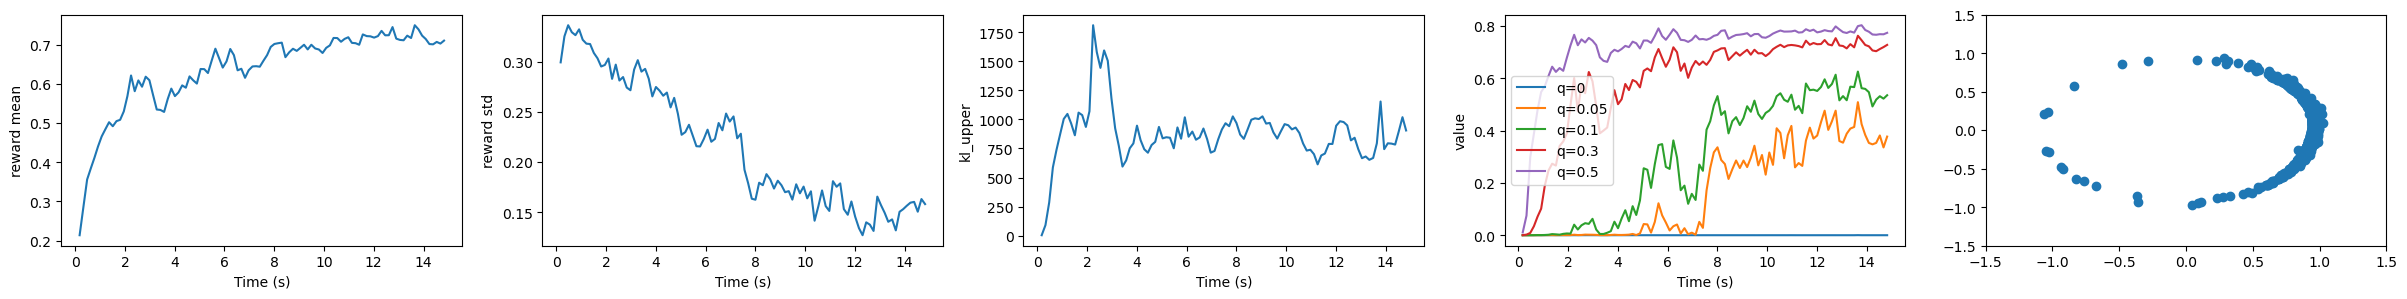

In [59]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 10
num_steps_per_epoch = 100
lr=1e-4
batch_size = 10
eta = 0.2
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

def weighted_denoising_loss(net, batch_data, batch_weights, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.view(-1,1)) + torch.sqrt(noisy_levels.view(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean(batch_weights * torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

log_interval = 10
eval_dataset_size = 1000
visualize = False
wrl_stats = logger()

# generate the offline dataset for finetuning
sampling_budget = 100
offline_dataset = ddim_sampling(model, sampling_budget, total_steps=50, eta = 1)
reward_data = reward_fn(offline_dataset)
offline_dataset = torch.FloatTensor(offline_dataset).cuda()
reward_data = torch.FloatTensor(reward_data).cuda()

progress = tqdm(range(EPOCH))
num_backprop = 0
idx_iter = iter(index_iterator(len(offline_dataset), batch_size))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(offline_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = offline_dataset[batch_idx]
        batch_reward = reward_data[batch_idx]
        batch_weights = torch.exp(batch_reward / eta)
        loss  = weighted_denoising_loss(aligned_model, batch_data, batch_weights)
        loss.backward()
        num_backprop += len(batch_data)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            eval_sample_points, eval_kl_upper = ddim_sampling_with_kl(aligned_model, model, eval_dataset_size, total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            wrl_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            progress.set_postfix(wrl_stats.get_postfix())

# plot
wrl_stats.visualize()

### 2. online weighted reward loss

  0%|          | 0/10 [00:00<?, ?it/s, reward_mean=0.227, reward_std=0.307, num_backprop=210, kl_upper=118]

100%|██████████| 10/10 [00:15<00:00,  1.54s/it, reward_mean=0.797, reward_std=0.019, num_backprop=9910, kl_upper=875]    


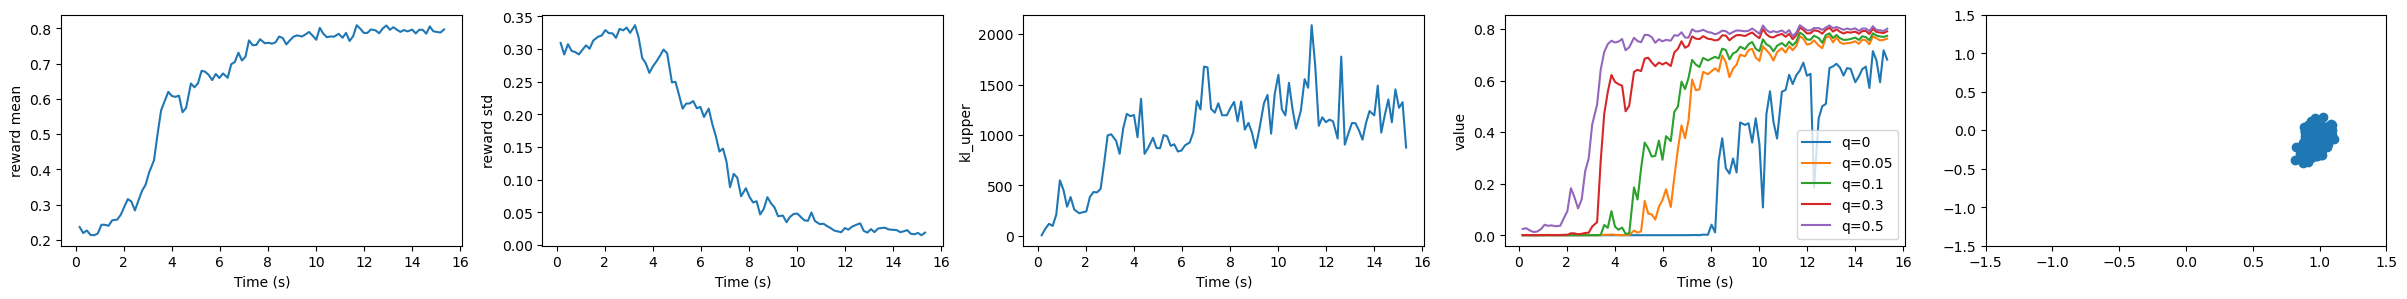

In [60]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 10
sample_points_per_epoch = sampling_budget // EPOCH
num_steps_per_epoch = 100
lr=1e-4
batch_size = 10
eta = 0.5
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

online_wrl_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0

for epoch in progress:
    avg_loss = 0
    totals = 0

    sampled_dataset = ddim_sampling(aligned_model, sample_points_per_epoch, total_steps=50, eta = 1)
    sampled_reward = reward_fn(sampled_dataset)
    sampled_dataset = torch.FloatTensor(sampled_dataset).cuda()
    sampled_reward = torch.FloatTensor(sampled_reward).cuda()
    idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = sampled_dataset[batch_idx]
        batch_reward = sampled_reward[batch_idx]
        batch_weights = torch.exp(batch_reward / eta)
        loss  = weighted_denoising_loss(aligned_model, batch_data, batch_weights)
        loss.backward()
        num_backprop += len(batch_data)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            eval_sample_points, eval_kl_upper = ddim_sampling_with_kl(aligned_model, model, eval_dataset_size, total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            online_wrl_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            
            progress.set_postfix(online_wrl_stats.get_postfix())

# plot
online_wrl_stats.visualize()

### 3. DDPO 

  0%|          | 0/10 [00:00<?, ?it/s, reward_mean=0.228, reward_std=0.31, num_backprop=490, kl_upper=16.4]

100%|██████████| 10/10 [01:24<00:00,  8.48s/it, reward_mean=0.522, reward_std=0.289, num_backprop=240590, kl_upper=984]


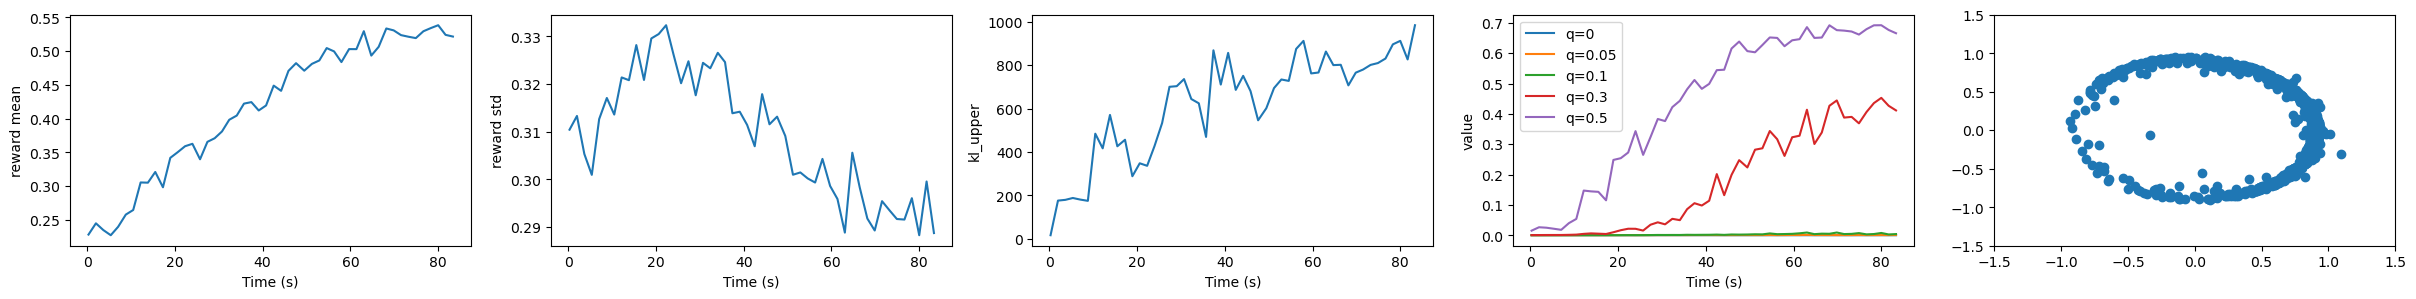

In [61]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 10
sample_points_per_epoch =  10 # sampling_budget // EPOCH
num_steps_per_epoch = 50
lr=1e-4
batch_size = 10
eta = 1
adv_clip_max = 5
clip_range = 0.1
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

ddpo_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0

for epoch in progress:
    avg_loss = 0
    totals = 0

    sampled_dataset, sampled_timesteps, logprob_timesteps, coeff_timesteps = ddim_sampling(aligned_model, sample_points_per_epoch, total_steps=50, eta = eta, return_all = True)
    sampled_reward = reward_fn(sampled_dataset)
    sampled_dataset = torch.FloatTensor(sampled_dataset).cuda()
    sampled_reward = torch.FloatTensor(sampled_reward).cuda()
    sampled_advantage = (sampled_reward - torch.mean(sampled_reward)) / (torch.std(sampled_reward) + 1e-8)
    idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = sampled_dataset[batch_idx]
        batch_reward = sampled_reward[batch_idx]
        batch_advantage = sampled_advantage[batch_idx]

        # main logic for computing policy gradient with importance sampling
        sample_loss = torch.zeros(len(batch_idx)).cuda()
        for timestep in range(0,len(sampled_timesteps)-1,1):
            logprob_old = logprob_timesteps[timestep][batch_idx]
            
            x_t = sampled_timesteps[timestep][batch_idx]
            x_t_next = sampled_timesteps[timestep+1][batch_idx]

            now_coeff = coeff_timesteps[timestep]
            next_coeff = coeff_timesteps[timestep+1]
            direction = aligned_model(x_t, torch.zeros(len(batch_idx)).cuda() + now_coeff)
            nl = eta * np.sqrt(next_coeff)
            new_x_t_next_mean = np.sqrt(1-next_coeff) * (x_t - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([next_coeff - nl**2, 0])) * direction

            logprob_new = - torch.sum(((x_t_next - new_x_t_next_mean) ** 2) / (2 * (nl**2)), dim = 1)

            ratio = torch.exp(logprob_new - logprob_old)

            # ppo logic
            cliped_advantage = torch.clamp(batch_advantage, -adv_clip_max, adv_clip_max)

            unclipped_loss = - ratio * cliped_advantage
            clipped_ratio = torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
            clipped_loss = - clipped_ratio * cliped_advantage
            

            sample_loss += torch.maximum(clipped_loss, unclipped_loss)
        
        loss = torch.mean(sample_loss)
        
        loss.backward()
        num_backprop += len(batch_data) * timestep
        # grad clipping
        torch.nn.utils.clip_grad_norm_(aligned_model.parameters(), 1)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            eval_sample_points, eval_kl_upper = ddim_sampling_with_kl(aligned_model,model, eval_dataset_size, total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            ddpo_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            progress.set_postfix(ddpo_stats.get_postfix())

# plot
ddpo_stats.visualize()

### 4. direct backpropogation - alignprop

  0%|          | 0/10 [00:00<?, ?it/s, reward_mean=0.228, reward_std=0.312, num_backprop=500, kl_upper=11.1]

100%|██████████| 10/10 [00:14<00:00,  1.45s/it, reward_mean=0.878, reward_std=0.00388, num_backprop=45500, kl_upper=2.67e+4]


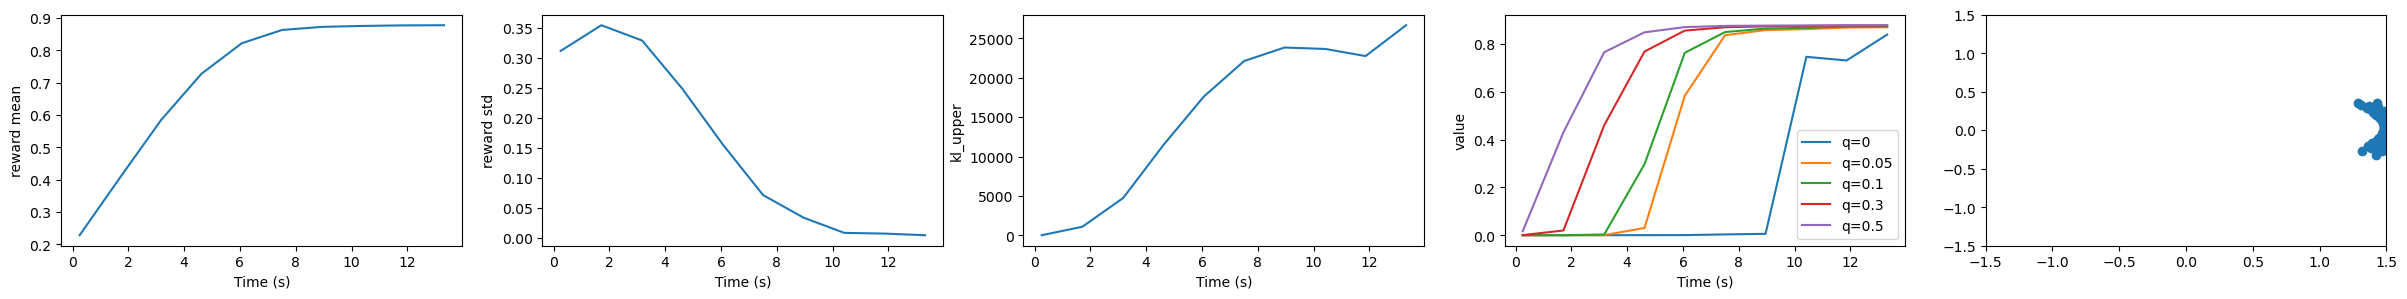

In [62]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 10
num_steps_per_epoch = 10
lr=1e-4
batch_size = 10
eta = 1
sample_time_steps = 50
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

def ddim_sampling_with_backprop(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        
        sample_points = sample_mean + nl * torch.randn(sample_size,2).cuda()
        
        now_coeff -= interp

    return sample_points

differetiable_reward_fn = lambda x: 1 / (1 + torch.exp(2* (x[:,0] - 1.5) ** 2  +2*(x[:,1] - 0) ** 2 - 2))

alignprop_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0

for epoch in progress:
    avg_loss = 0
    totals = 0

    for step in range(num_steps_per_epoch):

        optimizer.zero_grad()
        batch_data = ddim_sampling_with_backprop(aligned_model, batch_size, total_steps=sample_time_steps, eta = eta)
        batch_reward = differetiable_reward_fn(batch_data)
        loss = - torch.mean(batch_reward )
        
        loss.backward()
        # grad clipping
        torch.nn.utils.clip_grad_norm_(aligned_model.parameters(), 1)
        num_backprop += len(batch_data) * sample_time_steps

        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            eval_sample_points, eval_kl_upper = ddim_sampling_with_kl(aligned_model,model, eval_dataset_size, total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            alignprop_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

        
            progress.set_postfix(alignprop_stats.get_postfix())

# plot
alignprop_stats.visualize()

### 5. conditional generation - offline

  0%|          | 0/10 [00:00<?, ?it/s, reward_mean=0.231, reward_std=0.303, num_backprop=10, kl_upper=561]

100%|██████████| 10/10 [00:15<00:00,  1.59s/it, reward_mean=0.637, reward_std=0.209, num_backprop=9910, kl_upper=942]   


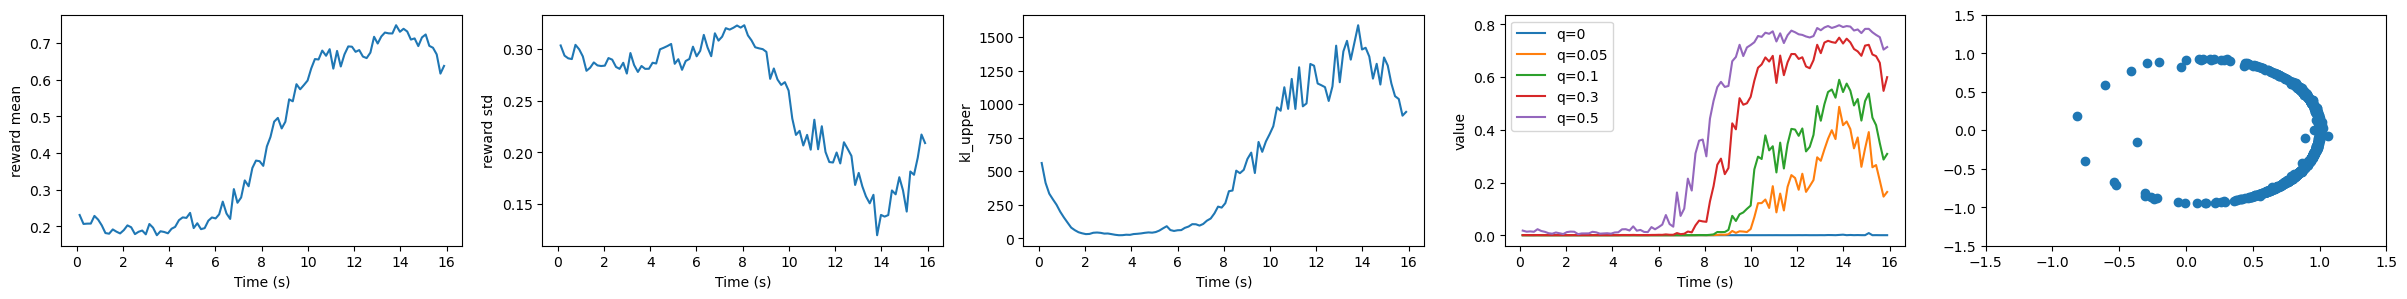

In [63]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

def conditional_denoising_loss(net, base_net,  batch_data, batch_cond, guidance_scale = 1, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.view(-1,1)) + torch.sqrt(noisy_levels.view(-1,1)) * noise
    with torch.no_grad():
        predicted_noise_uncond = base_net(noisy_data, noisy_levels)
    predicted_noise_cond = net(noisy_data, noisy_levels, batch_cond.view(-1,1))
    total_predict_noise = predicted_noise_uncond + guidance_scale * predicted_noise_cond
    loss  = torch.mean(torch.sum((total_predict_noise - noise)**2, dim = 1)) 
    return loss

def cond_ddim_sampling_with_kl(model, ref_model, use_cond, sample_size = 100, guidance_scale = 1, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    if type(use_cond) is float:
        use_cond = torch.zeros(sample_size, 1).cuda() + use_cond

    kl = 0
    for _ in range(total_steps):
        nl = eta * np.sqrt(max([now_coeff - interp, 0])) 
      
        with torch.no_grad():
            ref_direction = ref_model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            cond_direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff, use_cond)
            direction = ref_direction + guidance_scale * cond_direction
            
        sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction
        ref_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * ref_direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * ref_direction
        sample_points = sample_mean + nl * torch.randn(sample_size,2).cuda()
        kl += torch.sum(((sample_mean - ref_mean) / nl) ** 2, dim = 1).mean()
        
        now_coeff -= interp
    return sample_points.cpu().numpy(), kl

EPOCH = 10
num_steps_per_epoch = 100
lr=1e-4
batch_size = 10
guidance_scale = 0.2
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

crl_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0
idx_iter = iter(index_iterator(len(offline_dataset), batch_size))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(offline_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = offline_dataset[batch_idx]
        batch_reward = reward_data[batch_idx]

        loss  = conditional_denoising_loss(aligned_model, model,  batch_data, batch_reward, guidance_scale=guidance_scale)
        loss.backward()
        num_backprop += len(batch_data)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            use_cond = reward_data.max().item()
            eval_sample_points, eval_kl_upper = cond_ddim_sampling_with_kl(aligned_model, model, use_cond, eval_dataset_size, guidance_scale=guidance_scale,  total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            crl_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            progress.set_postfix(crl_stats.get_postfix())
            

# plot
crl_stats.visualize()

### 6. conditional generation - online

  0%|          | 0/4 [00:00<?, ?it/s, reward_mean=0.213, reward_std=0.294, num_backprop=10, kl_upper=580]

100%|██████████| 4/4 [00:26<00:00,  6.60s/it, reward_mean=0.798, reward_std=0.0363, num_backprop=13265, kl_upper=1.36e+3]


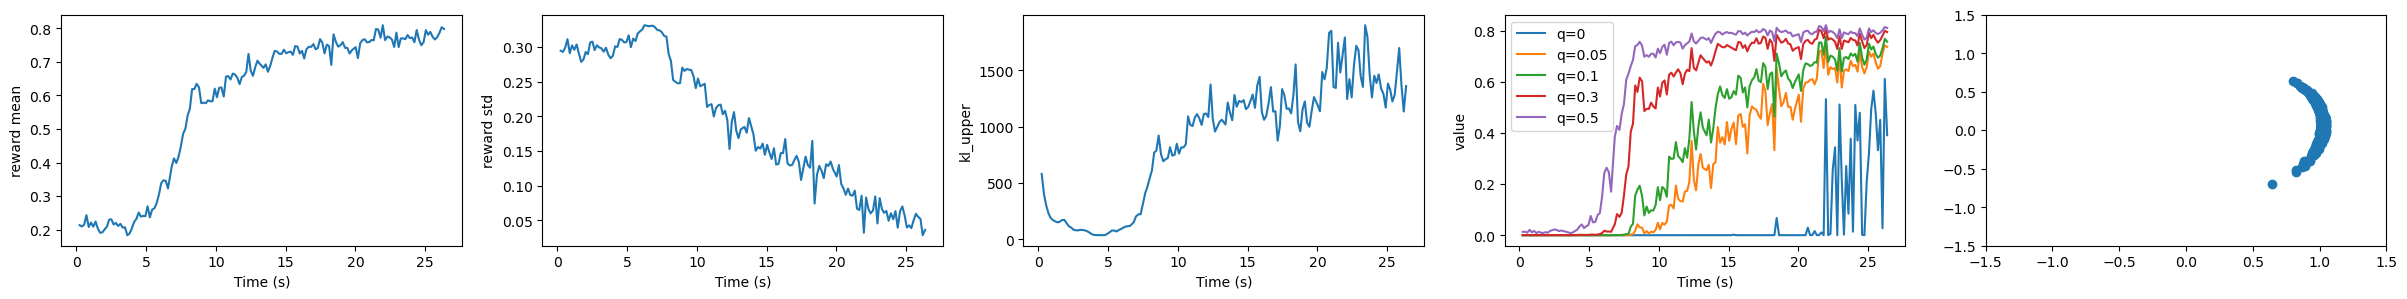

In [64]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 4
sample_points_per_epoch = sampling_budget // EPOCH
num_steps_per_epoch = 400
lr=1e-4
batch_size = 10
guidance_scale = 0.2
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

online_crl_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0

all_reward = [0.]
for epoch in progress:
    avg_loss = 0
    totals = 0

    use_cond = max(all_reward)
    sampled_dataset, _ = cond_ddim_sampling_with_kl(aligned_model, model, use_cond, sample_points_per_epoch,guidance_scale = guidance_scale if epoch > 0 else 0,  total_steps=50, eta = 1)
    sampled_reward = reward_fn(sampled_dataset)
    all_reward.extend(sampled_reward.tolist())
    sampled_dataset = torch.FloatTensor(sampled_dataset).cuda()
    sampled_reward = torch.FloatTensor(sampled_reward).cuda()
    idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = sampled_dataset[batch_idx]
        batch_reward = sampled_reward[batch_idx]
        loss  = conditional_denoising_loss(aligned_model, model,  batch_data, batch_reward, guidance_scale=guidance_scale)
        loss.backward()
        # grad clipping
        torch.nn.utils.clip_grad_norm_(aligned_model.parameters(), 1)

        num_backprop += len(batch_data)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            use_cond = max(all_reward)
            eval_sample_points, eval_kl_upper = cond_ddim_sampling_with_kl(aligned_model, model, use_cond, eval_dataset_size, guidance_scale=guidance_scale,  total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            online_crl_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)

            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            progress.set_postfix(online_crl_stats.get_postfix())

# plot
online_crl_stats.visualize()

### 7. best-of-k generation

  1%|          | 1/100 [00:00<00:21,  4.69it/s, reward_mean=0.226, reward_std=0.303, num_backprop=10, kl_upper=5.34]

100%|██████████| 100/100 [00:20<00:00,  4.77it/s, reward_mean=0.88, reward_std=0.000913, num_backprop=9910, kl_upper=1.76e+4]


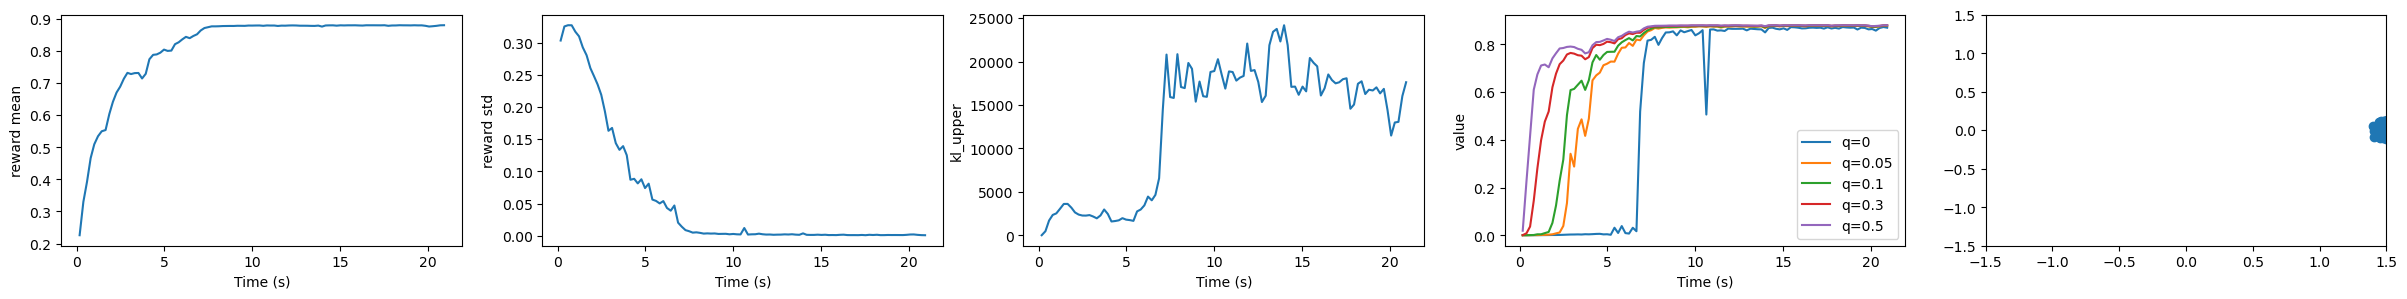

In [65]:
aligned_model = UNet_MLP(data_dim, 1, 1).cuda()
aligned_model.load_state_dict(torch.load("ddim_ema_mg.pth"))

EPOCH = 100
sample_points_per_epoch = 100
bestk = 10
num_steps_per_epoch = 10
lr=1e-4
batch_size = 10
optimizer = torch.optim.Adam(aligned_model.parameters(), lr=lr)

def denoising_loss(net, batch_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

bestk_stats = logger()
log_interval = 10
eval_dataset_size = 1000
visualize = False

progress = tqdm(range(EPOCH))
num_backprop = 0

for epoch in progress:
    avg_loss = 0
    totals = 0

    sampled_dataset = ddim_sampling(aligned_model,sample_points_per_epoch, total_steps=50, eta = 1)
    sampled_reward = reward_fn(sampled_dataset)
    # sample the best k with highest reward
    bestk_idx = np.argsort(sampled_reward)[-bestk:]
    sampled_dataset = sampled_dataset[bestk_idx]
    sampled_dataset = torch.FloatTensor(sampled_dataset).cuda()

    idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
    for step in range(num_steps_per_epoch):
        
        try:
            batch_idx = next(idx_iter)
        except:
            idx_iter = iter(index_iterator(len(sampled_dataset), batch_size))
            batch_idx = next(idx_iter)

        optimizer.zero_grad()
        batch_data = sampled_dataset[batch_idx]
        loss  = denoising_loss(aligned_model,  batch_data)
        loss.backward()
        # grad clipping
        torch.nn.utils.clip_grad_norm_(aligned_model.parameters(), 1)

        num_backprop += len(batch_data)
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

        if step % log_interval == 0:
            eval_sample_points, eval_kl_upper = ddim_sampling_with_kl(aligned_model, model, eval_dataset_size,  total_steps=50, eta = 1)
            # logging
            eval_rewards = reward_fn(eval_sample_points)
            bestk_stats.update(eval_rewards, eval_sample_points, num_backprop, eval_kl_upper)
            if visualize:
                plt.figure(figsize=(2,2))
                plt.scatter(eval_sample_points[:,0], eval_sample_points[:,1], s=5, alpha=0.6)
                plt.xlim(-1.5,1.5)
                plt.ylim(-1.5,1.5)
                plt.title("epoch:{}".format(epoch))
                plt.show()

            progress.set_postfix(bestk_stats.get_postfix())

# plot
bestk_stats.visualize()